In [27]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt
from skimage.io import imread

In [28]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/data/train/DCM"
LABEL_ROOT = "/Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/data/train/outputs_json"

In [29]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [30]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [31]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [32]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [33]:
len(pngs)

800

In [34]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [35]:
len(jsons)

800

In [36]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

In [37]:
pngs = sorted(pngs)
jsons = sorted(jsons)

In [38]:
pngs = np.array(pngs)
jsons = np.array(jsons)

# 데이터셋 정의

In [39]:
class XRayDataset(Dataset):
    def __init__(self, filenames, labelnames, transforms=None, is_train=False):
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)

        image = cv2.imread(image_path)
        image = image / 255.

        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)

        # process a label of shape (H, W, NC)
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)

        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]

        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])

            # polygon to mask
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label

        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)

            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        label = label.transpose(2, 0, 1)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()

        return image, label

In [40]:
train_filenames = list(pngs)  # pngs 전체를 train으로 사용
train_labelnames = list(jsons)  # jsons 전체를 train으로 사용

In [54]:
print(train_filenames)

['ID001/image1661130828152_R.png', 'ID001/image1661130891365_L.png', 'ID002/image1661144206667.png', 'ID002/image1661144246917.png', 'ID003/image1661144310162.png', 'ID003/image1661144351691.png', 'ID004/image1661144691792.png', 'ID004/image1661144724044.png', 'ID005/image1661144825412.png', 'ID005/image1661144852117.png', 'ID006/image1661145075929.png', 'ID006/image1661145103549.png', 'ID007/image1661145193855.png', 'ID007/image1661145229731.png', 'ID008/image1661145286692.png', 'ID008/image1661145313061.png', 'ID009/image1661145407161.png', 'ID009/image1661145432967.png', 'ID010/image1661145563354.png', 'ID010/image1661145591320.png', 'ID011/image1661146664360.png', 'ID011/image1661146685158.png', 'ID012/image1661147072358.png', 'ID012/image1661147098202.png', 'ID013/image1661216747360.png', 'ID013/image1661216788592.png', 'ID014/image1661216876670.png', 'ID014/image1661216907060.png', 'ID015/image1661216971933.png', 'ID015/image1661216998230.png', 'ID016/image1661217116456.png', 'ID

# Mask 시각화

In [41]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)

    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]

    return image

In [42]:
tf = A.Resize(512, 512)

In [43]:
train_dataset = XRayDataset(train_filenames, train_labelnames, transforms=tf, is_train=True)

In [44]:
image, label = train_dataset[1]

In [45]:
print(image.shape, label.shape)

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])


In [46]:
len(train_dataset)

800

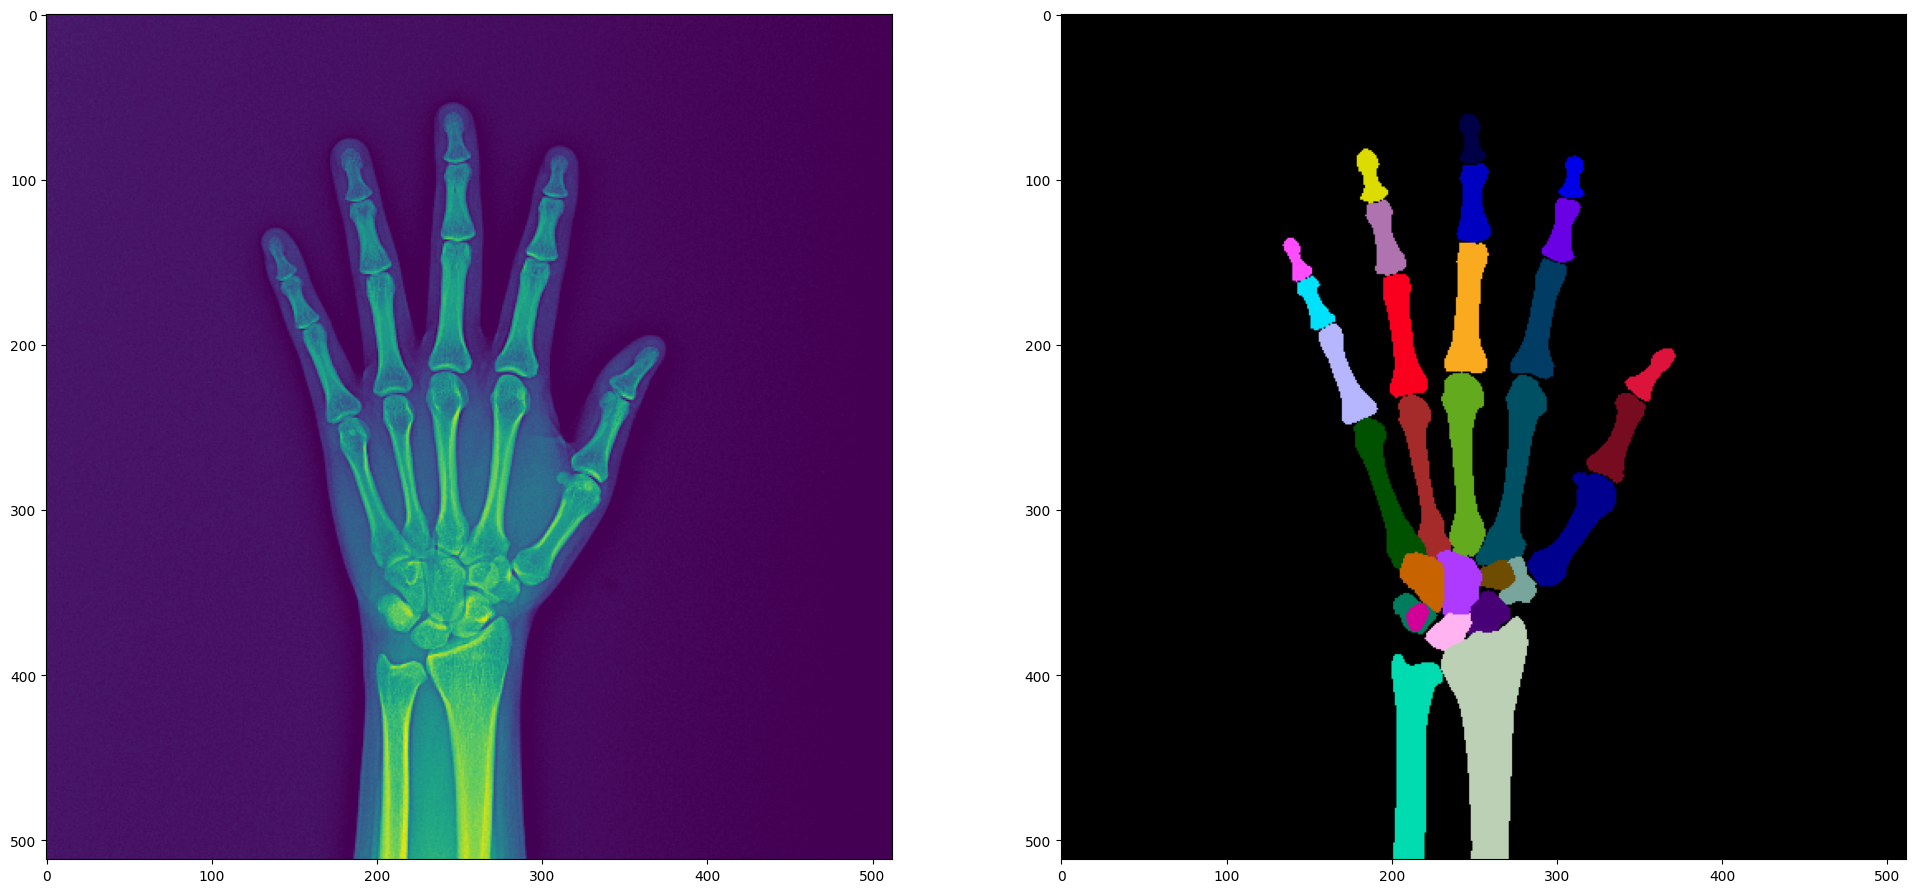

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # remove channel dimension
ax[1].imshow(label2rgb(label))

plt.show()

# 원본 이미지 & Mask 시각화 한 파일로 저장

In [50]:
VISUALIZATION_ROOT = '/Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/visualization'

In [59]:
# Function to process and visualize images
def visualize_images_and_labels(image, label, output_filename):

    if image is None or label is None:
        print(f"Error: Image or label is None. Cannot visualize {output_filename}.")
        return  # If either image or label is None, return without processing

    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image[0])  # 원본 이미지 (채널 차원 제거)
    ax[0].axis('off')  # 축을 숨깁니다.
    ax[1].imshow(label2rgb(label))  # 라벨을 색상으로 변환한 이미지
    ax[1].axis('off')  # 축을 숨깁니다.

    # 이미지를 파일로 저장 (PNG 형식)
    fig.tight_layout()
    plt.savefig(output_filename, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    print(f"이미지가 {output_filename}로 저장되었습니다.")

In [60]:
# Create directories for visualization if they don't exist
if not os.path.exists(VISUALIZATION_ROOT):
    os.makedirs(VISUALIZATION_ROOT)

In [63]:
# Iterate through all IDs (ID001 to ID548) and process images
for i in tqdm(range(1, 549)):
    # Generate the ID folder name (e.g., ID001, ID002, ..., ID548)
    id_folder = f"ID{i:03d}"

    # Create folder for this ID inside the visualization directory
    id_output_folder = os.path.join(VISUALIZATION_ROOT, id_folder)
    if not os.path.exists(id_output_folder):
        os.makedirs(id_output_folder)

    # Get list of all train filenames and labels
    train_filenames = list(pngs)  # pngs 전체를 train으로 사용
    train_labelnames = list(jsons)  # jsons 전체를 train으로 사용

    # Filter the filenames for the current ID, making sure to keep only filenames that correspond to the current ID
    id_filenames = [filename for filename in train_filenames if f"ID{i:03d}" in filename]
    id_labelnames = [label for label in train_labelnames if f"ID{i:03d}" in label]

    # Create the dataset and apply transformations
    transform = A.Resize(512, 512)
    dataset = XRayDataset(id_filenames, id_labelnames, transforms=transform, is_train=True)

    # Process images for the current ID
    for filename, labelname in zip(id_filenames, id_labelnames):
        try:
            # Get the corresponding image and label
            image, label = dataset[dataset.filenames.index(filename)]  # Get the image from dataset
    
            # Check if the image is None
            if image is None:
                print(f"Warning: Unable to load image from {filename}, skipping.")
                continue  # Skip this iteration if image is None
            
            # Check if label is None (optional, depending on the data)
            if label is None:
                print(f"Warning: Unable to load label from {labelname}, skipping.")
                continue  # Skip this iteration if label is None
            
            # Generate the correct output filename for visualization
            output_filename = os.path.join(id_output_folder, f"{os.path.basename(filename).split('.')[0]}_vis.png")
    
            # Visualize and save the image
            visualize_images_and_labels(image, label, output_filename)
    
        except Exception as e:
            print(f"Error processing {filename}: {e}")



  0%|          | 0/85 [00:00<?, ?it/s]

이미지가 /Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/visualization/ID464/image1666575941104_vis.png로 저장되었습니다.
이미지가 /Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/visualization/ID464/image1666575957671_vis.png로 저장되었습니다.
이미지가 /Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/visualization/ID465/image1666576283901_vis.png로 저장되었습니다.
이미지가 /Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/visualization/ID465/image1666576298467_vis.png로 저장되었습니다.
이미지가 /Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/visualization/ID466/image1666659456059_vis.png로 저장되었습니다.
이미지가 /Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/visualization/ID466/image1666659483137_vis.png로 저장되었습니다.
이미지가 /Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/visualization/ID467/image1666659745388_vis.png로 저장되었습니다.
이미지가 /Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Seg

# R, L 손 파일명으로 구분

In [67]:
import os

# 이미지 파일의 경로를 지정하세요
base_path = "/Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/data/train/DCM"

# ID 폴더들을 탐색합니다
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    
    # 폴더 내 파일들을 가져옵니다 (이미지 파일이 두 개라고 가정)
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.startswith("image") and f.endswith(".png")]
        
        # 숫자 기준으로 정렬합니다
        image_files.sort(key=lambda x: int(x.split("image")[1].split("_")[0].split(".")[0]))

        # 작은 숫자에 _R, 큰 숫자에 _L을 붙입니다
        for i, file in enumerate(image_files):
            if not ("_R" in file or "_L" in file):  # _R 또는 _L이 없는 파일만 수정
                new_name = file.replace(".png", "_R.png") if i == 0 else file.replace(".png", "_L.png")
                os.rename(os.path.join(folder_path, file), os.path.join(folder_path, new_name))
                print(f"{file} -> {new_name}")


image1666746347755.png -> image1666746347755_R.png
image1666746376659.png -> image1666746376659_L.png
image1661145286692.png -> image1661145286692_R.png
image1661145313061.png -> image1661145313061_L.png
image1661318779413.png -> image1661318779413_R.png
image1661318805314.png -> image1661318805314_L.png
image1666573743950.png -> image1666573743950_R.png
image1666573768043.png -> image1666573768043_L.png
image1666573825661.png -> image1666573825661_R.png
image1666573854736.png -> image1666573854736_L.png
image1661317062396.png -> image1661317062396_R.png
image1661317091360.png -> image1661317091360_L.png
image1665536522908.png -> image1665536522908_R.png
image1665536548947.png -> image1665536548947_L.png
image1665450951082.png -> image1665450951082_R.png
image1665450970862.png -> image1665450970862_L.png
image1667179311111.png -> image1667179311111_R.png
image1667179338069.png -> image1667179338069_L.png
image1666749288019.png -> image1666749288019_R.png
image1666749315607.png -> image

# EDA

### 클래스별 갯수

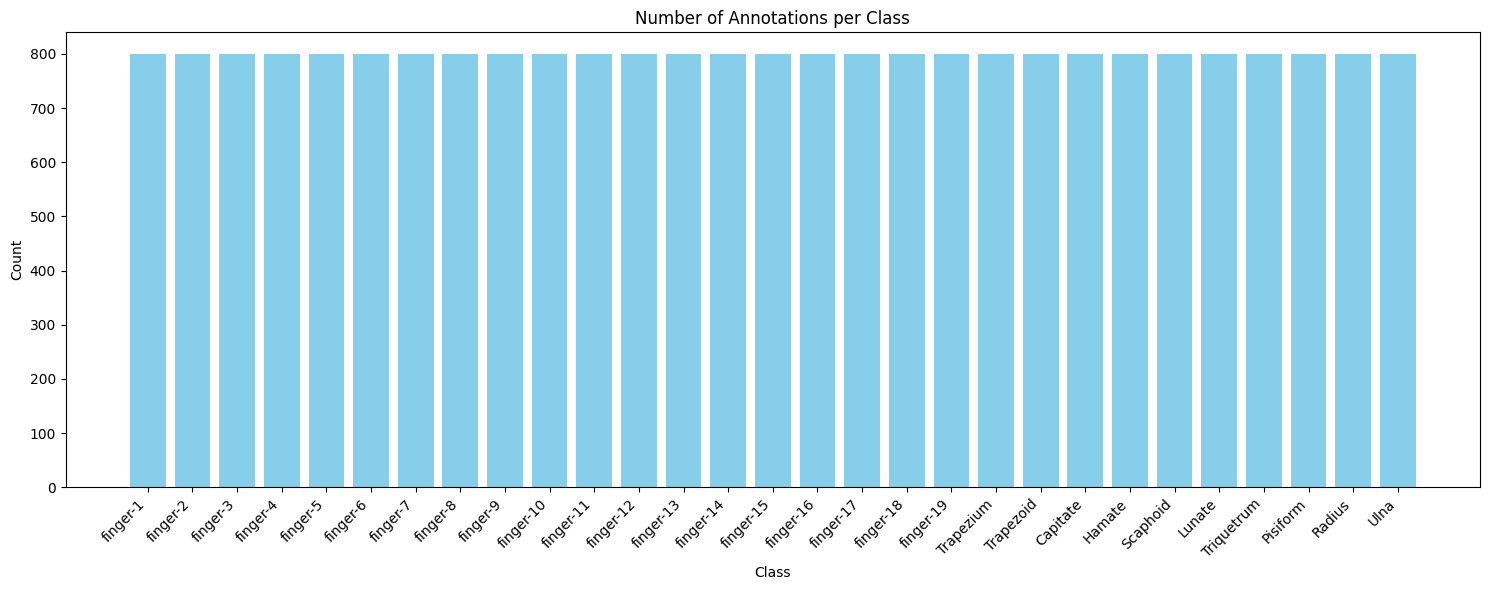

In [64]:
from collections import defaultdict

# 클래스별 갯수를 세기 위한 딕셔너리 초기화
class_counts = defaultdict(int)

# 모든 라벨 파일 탐색 및 클래스 갯수 세기
for root, dirs, files in os.walk(LABEL_ROOT):
    for file in files:
        if file.endswith(".json"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                data = json.load(f)
                for annotation in data["annotations"]:
                    label = annotation["label"]
                    if label in CLASSES:
                        class_counts[label] += 1

# 막대 그래프 그리기
plt.figure(figsize=(15, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Annotations per Class')
plt.tight_layout()
plt.show()

In [68]:
# 딕셔너리를 DataFrame으로 변환
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
# 인덱스 번호대로 정렬
df = df.sort_index()


# DataFrame 출력
print(df)

         Class  Count
0     finger-1    800
1     finger-2    800
2     finger-3    800
3     finger-4    800
4     finger-5    800
5     finger-6    800
6     finger-7    800
7     finger-8    800
8     finger-9    800
9    finger-10    800
10   finger-11    800
11   finger-12    800
12   finger-13    800
13   finger-14    800
14   finger-15    800
15   finger-16    800
16   finger-17    800
17   finger-18    800
18   finger-19    800
19   Trapezium    800
20   Trapezoid    800
21    Capitate    800
22      Hamate    800
23    Scaphoid    800
24      Lunate    800
25  Triquetrum    800
26    Pisiform    800
27      Radius    800
28        Ulna    800


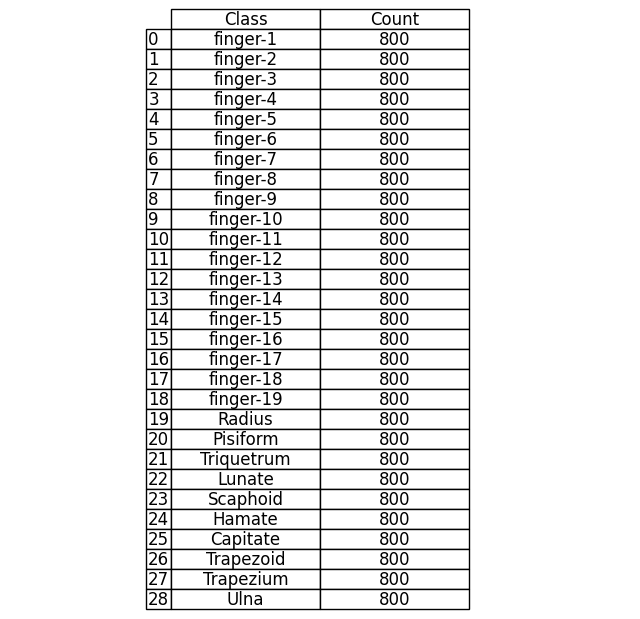

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# 데이터 준비
class_counts = {
    'finger-1': 800, 'finger-2': 800, 'finger-3': 800, 'finger-4': 800, 'finger-5': 800,
    'finger-6': 800, 'finger-7': 800, 'finger-8': 800, 'finger-9': 800, 'finger-10': 800,
    'finger-11': 800, 'finger-12': 800, 'finger-13': 800, 'finger-14': 800, 'finger-15': 800,
    'finger-16': 800, 'finger-17': 800, 'finger-18': 800, 'finger-19': 800, 'Radius': 800,
    'Pisiform': 800, 'Triquetrum': 800, 'Lunate': 800, 'Scaphoid': 800, 'Hamate': 800,
    'Capitate': 800, 'Trapezoid': 800, 'Trapezium': 800, 'Ulna': 800
}

# 딕셔너리를 DataFrame으로 변환
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# 인덱스 번호대로 정렬
df = df.sort_index()

# Matplotlib을 이용한 표 이미지 시각화
fig, ax = plt.subplots(figsize=(8, 6))  # 표의 크기 설정
ax.axis('off')  # 축 없애기

# DataFrame을 테이블로 변환하여 표시
tabla = table(ax, df, loc='center', cellLoc='center', colWidths=[0.2, 0.2])

# 테이블 스타일 설정
tabla.auto_set_font_size(False)  # 글자 크기 자동 조정
tabla.set_fontsize(12)  # 글자 크기 설정
tabla.scale(1.2, 1.2)  # 테이블 크기 조정

# 이미지로 저장
plt.savefig("table_image.png", bbox_inches="tight", dpi=300)
plt.show()
